In [163]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

## SGD on weather radar image

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from regression import OLS

In Project 1 we used matrix inversion to solve the equations for OLS and Ridge. In this exercise I will solve the same equations using stocastic gradient descent. I have choosen to continue with the same weather radar image as I used in the first project:

SDG på værradar:
- Sammenlign med svaret fra skicit learn. Her skal det være ein SGD option som gjer at eg får samme matrise som over. ulike treff for 2 ulike parameter. 
- Gjer scalering riktig. Bruk cross validation og undersøk bootstrap dersom tid. 
- slides fra week 40 og seaborn er bra. 
- Gjer meg opp ein meining om cost-funksjon? ABS eller MSE? 
- sjå på korleis beta verdiane forbedrer seg for kvar iterasjon? Det kunne jo vært ult, men krev mange dimensjonar.
- Bruk autograd for derivering:) 

In [5]:
radar = np.load("nedbor_radar.npy") # from 2021-10-06 kl 11:45

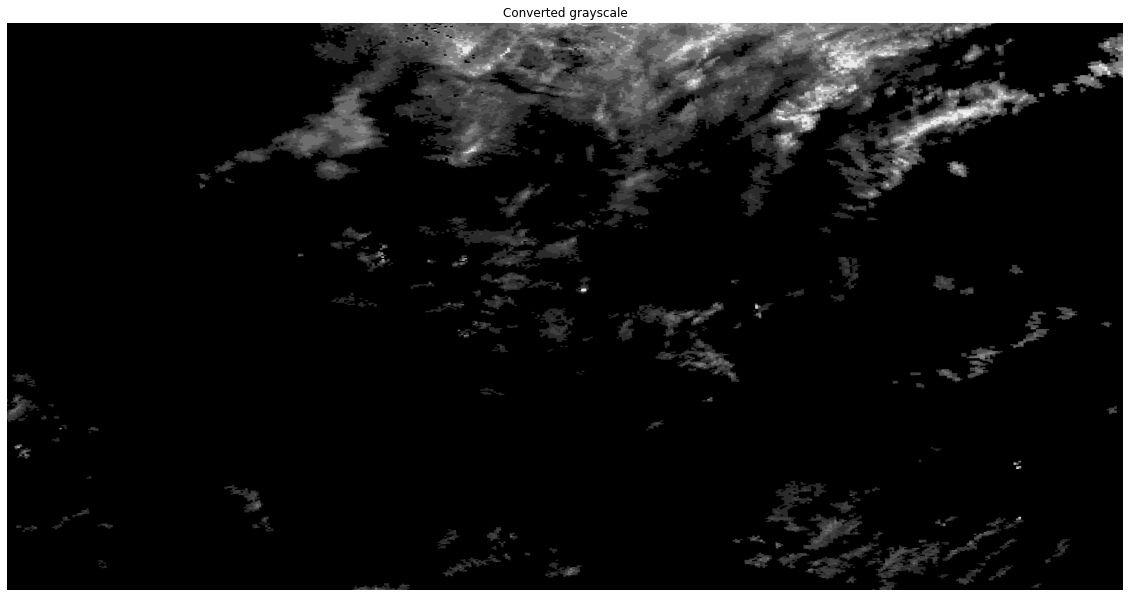

In [11]:
import matplotlib.image as mpimg
fig, ax = plt.subplots(1, 1, figsize=(20,15))
ax.imshow(radar, cmap='gray')
ax.set_title('Converted grayscale')

plt.axis('off')
plt.show()

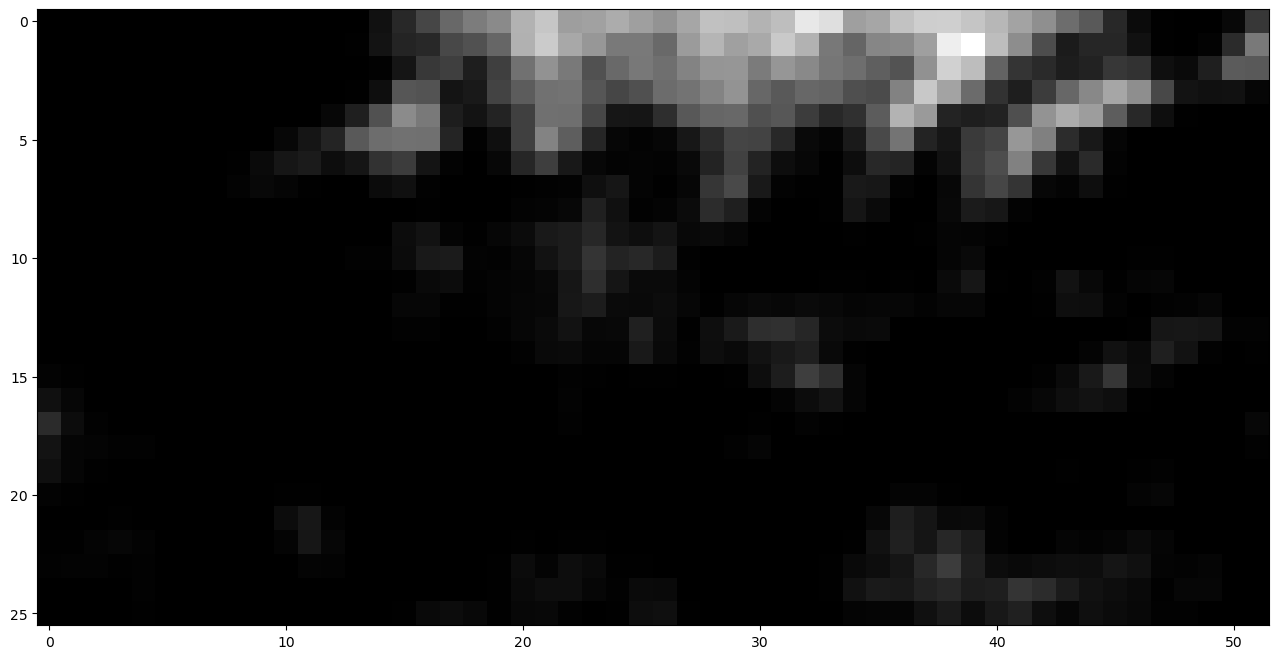

In [420]:
from skimage.transform import rescale
scale_factor = 0.015 # 0.015 and lower gives over-fitting tendencies
radar_rescaled = rescale(radar, scale_factor)

fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(radar_rescaled, cmap='gray')
plt.show()

In [480]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm # progressbar

# my own library
from regression import OLS

#sk-learn linear regression for lasso analysis
#from sklearn.linear_model import Lasso as Lasso_skl
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import PolynomialFeatures

z = radar_rescaled
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

poly = 7
k_folds = 7

MSE_test_OLS = [] 
MSE_train_OLS = []
betas_OLS = []

MSE_test_Ridge = [] 
MSE_train_Ridge = []
betas_Ridge = []
MSE_test_Ridge_l = [] 
MSE_train_Ridge_l = []
betas_Ridge_l = []

MSE_test_Lasso = [] 
MSE_train_Lasso = []
betas_Lasso = []
MSE_test_Lasso_l = [] 
MSE_train_Lasso_l = []
betas_Lasso_l = []

# Cross validation:
# shuffle data:
x =  ((x.ravel() - np.mean(x.ravel()))/np.sqrt(np.var(x.ravel()))) 
y =  ((y.ravel() - np.mean(y.ravel()))/np.sqrt(np.var(y.ravel()))) 
z =  ((z.ravel() - np.mean(z.ravel()))/np.sqrt(np.var(z.ravel()))) 
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle)
xyz_folds = np.array_split(xyz_shuffle, k_folds) # split into k-folds

for k in tqdm.tqdm(range(k_folds)):     
    # extract folds
    
    xyz_test = xyz_folds[k] # k-th fold is test 
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    #Scale groups separately

    #xy_test[:, 0] =  ((xy_test[:, 0] - np.mean(xy_test[:, 0]))/np.sqrt(np.var(xy_test[:, 0]))) 
    #xy_test[:, 1] =  ((xy_test[:, 1] - np.mean(xy_test[:, 1]))/np.sqrt(np.var(xy_test[:, 1])))
    #z_test[:] =  ((z_test[:] - np.mean(z_test[:]))/np.sqrt(np.var(z_test[:])))  
    
    # OLS:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    #p_degree: 1      2      3      4      5      6      7      8      9     10     11
    #t_0 = [0.01,   0.001,   0.1,  0.01,  0.01,  0.01,  0.01, 0.005,     1,     1,     1]
    #t_1 = [100,     1000,    100, 10000, 10000, 10000,  1000,  1000, 10000, 10000, 10000]
    learning_rate = [0.001, 0.001, 0.001, 0.001, 0.0002, 0.0005, 0.0001, 0.0001]
    for poly_deg in range(1, poly + 1):
        def learning_schedule(t):
            #return t_0[poly_deg - 1]/(t_1[poly_deg - 1] + t)
            return learning_rate[poly_deg - 1]
            #return (0.1**(0.1*poly_deg))*0.0001/(1 + 0.001*t)
        model = OLS(poly_deg, learning_schedule, batch_size=1, n_epochs=50)
        model.fit(xy_train, z_train) 
        MSE_test.append(model.MSE(xy_test, z_test)) 
        MSE_train.append(model.MSE(xy_train, z_train))
    MSE_test_OLS.append(MSE_test) 
    MSE_train_OLS.append(MSE_train)

    # Ridge:
    #MSE_test = []
    #MSE_train = []
    #beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    #lambda_ridge = 50
    #for poly_deg in range(1, poly + 1):
    #    model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge) 
    #    MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
    #    MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
    #    beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
    #    beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
    #    
    #MSE_test_Ridge.append(MSE_test) 
    #MSE_train_Ridge.append(MSE_train)
    #betas_Ridge.append(beta_poly) 
    
#convert to array
MSE_test_OLS = np.array(MSE_test_OLS)
MSE_train_OLS = np.array(MSE_train_OLS)

MSE_test_Ridge = np.array(MSE_test_Ridge)
MSE_train_Ridge = np.array(MSE_train_Ridge)

#study average values
expected_MSE_test_OLS = np.mean(MSE_test_OLS, axis=0) 
expected_MSE_train_OLS  = np.mean(MSE_train_OLS, axis=0)

100%|███| 7/7 [00:30<00:00,  4.42s/it]


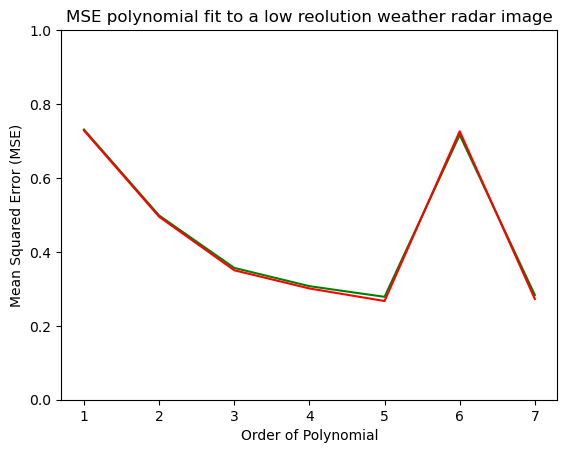

In [479]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_OLS, 'g', label='OLS test')
plt.plot(range(1, len(MSE_train)+1), expected_MSE_train_OLS, 'r', label='OLS train')

plt.xlabel('Order of Polynomial')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE polynomial fit to a low reolution weather radar image')
plt.ylim(0, 1)
plt.show()

## Predict weather image

In [ ]:
Prøv med enkelt-polynomgrader: learning rates og ridge i matrise..